In [2]:
from urllib.request import urlopen, Request
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Normalizer
from urllib.request import urlopen
from matplotlib import pyplot as plt
import math
import datetime
from time import sleep
import copy
import json
import sys
import csv
import pandas as pd
import numpy as np
from scipy.stats.stats import pearsonr   
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectFromModel
from sklearn import svm
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.utils import shuffle
from statsmodels.stats.stattools import durbin_watson

In [231]:
def AutocorrelationTest(array):
    return durbin_watson(array)

def ReduceDates(dates):
    count = 0
    for date in dates:
        if count%5 != 0:
            dates[count] = ' '
        count += 1
    return dates        

def PlotColumn(df, columns, scaler = StandardScaler(), title=None, ylabel = None, xlabel = None):
    
    #color=np.random.rand(3,), label=column
    
    dff = df[columns].copy()
    dff['date'] = df['date']
    ax = plt.gca()
    ax.locator_params(nbins=40, axis='x')
    
    for column in columns:
        data = df[[column]]
        if scaler is not None:
            dff[column] = scaler.fit_transform(df[[column]])
       
        dff.plot(kind='line',x='date',y=column,ax=ax, figsize=(20,10),label=column)
        
        plt.xticks(rotation='80')
        plt.ylabel(ylabel, fontsize=25)
        plt.xlabel(xlabel, fontsize=25)
        plt.legend()
        plt.title(title, fontsize=40)
    
    del dff['date']
    return dff

def PlotCorrelationMatrix(dff, fontsize = 20):
    f = plt.figure(figsize=(20, 10))
    data = dff.corr();
    plt.matshow(data, fignum=f.number)
    
    for (i, j), z in np.ndenumerate(data):
        plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', fontsize=fontsize, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.xticks(range(dff.shape[1]), dff.columns, fontsize=14, rotation=90)
    plt.yticks(range(dff.shape[1]), dff.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    #plt.title('Correlation Matrix', fontsize=16);
    
def Predict(df, scaler = None, classifier = RandomForestClassifier(n_estimators=101, random_state=0), columns = None):
    print(df.shape)
    df.drop(df.tail(7).index,inplace=True) #missing data from news
    
    if columns is None:
        df = df.drop(['date','target_price', 'd_target_price'], axis = 1) # delete non-numeric columns
    else:
        target = df['target_rise_fall']
        df = df[columns].copy()
        df['target_rise_fall'] = target
        
    X = df.loc[:, df.columns != 'target_rise_fall']
    y = df.loc[:, df.columns == 'target_rise_fall']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    X_train_r = X_train.copy()
    if scaler is not None:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    classifier.fit(X_train, y_train.values.ravel())
    y_pred = classifier.predict(X_test)
    print("---------------------Summary------------------")
    print(classification_report(y_test,y_pred))
    print("----------------Confusion_matrix--------------")
    print(confusion_matrix(y_test,y_pred))
    print("--------------------Accuracy------------------")
    print(accuracy_score(y_test, y_pred))
    return  classifier , X_train_r
    
def DefineThreeClasses(df):
    df['target_rise_fall'] = np.where((df.target > 100.00),'Rise',df.target_rise_fall)
    df['target_rise_fall'] = np.where((df.target <-100.00),'Fall',df.target_rise_fall)
    df['target_rise_fall'] = np.where(((df.target >=-100) & (df.target <=100)),'Stay',df.target_rise_fall)
    print('Rise'+ str(df[df.target_rise_fall == 'Rise'].shape[0]))
    print('Fall'+ str(df[df.target_rise_fall == 'Fall'].shape[0]))
    print('Stay'+ str(df[df.target_rise_fall == 'Stay'].shape[0]))
    return df
    

# SUMAR TWITTER DATA - twitter volume a objem tweetov s nenulovou kategóriou sentimentu


In [269]:
df = pd.read_csv("data.csv")
dff = df[['date','open_price', 'close_price','tweet_volume', 'nonzero_neutral_tweet', 'nonzero_positive_tweet', 'nonzero_negative_tweet', 'nonzero_compound_tweet']].copy()
dff['target_price'] = dff['close_price'].shift(-1) 
dff['d_target_price'] = dff['target_price'] - dff['close_price']
#differences features
dff['d_price_move'] = dff.close_price - dff.open_price
##
dff['d_tweet_volume'] = np.insert(np.diff(dff['tweet_volume']), 0, 0)
dff['d_nonzero_neutral_tweet'] = np.insert(np.diff(dff['nonzero_neutral_tweet']), 0, 0)
dff['d_nonzero_positive_tweet'] = np.insert(np.diff(dff['nonzero_positive_tweet']), 0, 0)
dff['d_nonzero_negative_tweet'] = np.insert(np.diff(dff['nonzero_negative_tweet']), 0, 0)
dff['d_nonzero_compound_tweet'] = np.insert(np.diff(dff['nonzero_compound_tweet']), 0, 0)
dff = dff[:-1]
dff = dff.iloc[1:]
dff.head()

date  open_price  close_price  tweet_volume  nonzero_neutral_tweet  \
1  2019-03-27     3984.24      4087.07         78592                  78574   
2  2019-03-28     4087.58      4069.11         78766                  78750   
3  2019-03-29     4068.30      4098.37         70494                  70483   
4  2019-03-30     4092.14      4106.66         71713                  71702   
5  2019-03-31     4105.46      4105.40         62468                  62454   

   nonzero_positive_tweet  nonzero_negative_tweet  nonzero_compound_tweet  \
1                   45076                   16776                   41193   
2                   45490                   18361                   41168   
3                   40216                   16713                   35872   
4                   42099                   20265                   33713   
5                   35900                   15189                   31640   

   target_price  d_target_price  d_price_move  d_tweet_volume  \
1       4069.11          -17.96        102.83            5957   
2       4098.37           29.26        -18.47             174   
3       4106.66            8.29         30.07           -8272   
4       4105.40           -1.26         14.52            1219   
5       4158.18           52.78         -0.06           -9245   

   d_nonzero_neutral_tweet  d_nonzero_positive_tweet  \
1                     5958                      4543   
2                      176                       414   
3                    -8267                     -5274   
4                     1219                      1883   
5                    -9248                     -6199   

   d_nonzero_negative_tweet  d_nonzero_compound_tweet  
1                      -358                      4432  
2                      1585                       -25  
3                     -1648                     -5296  
4                      3552                     -2159  
5                     -5076                     -2073

Durbin-Watson test for target_price autocorrelation:  0.03176564675590628
Durbin-Watson test for tweet_volume autocorrelation:  1.0231423586061603
Durbin-Watson test for nonzero_neutral_tweet autocorrelation:  1.0179497272693074
Durbin-Watson test for nonzero_positive_tweet autocorrelation:  1.0134751512122915
Durbin-Watson test for nonzero_negative_tweet autocorrelation:  1.43995993188696
Durbin-Watson test for nonzero_compound_tweet autocorrelation:  0.9915954563482738
<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation


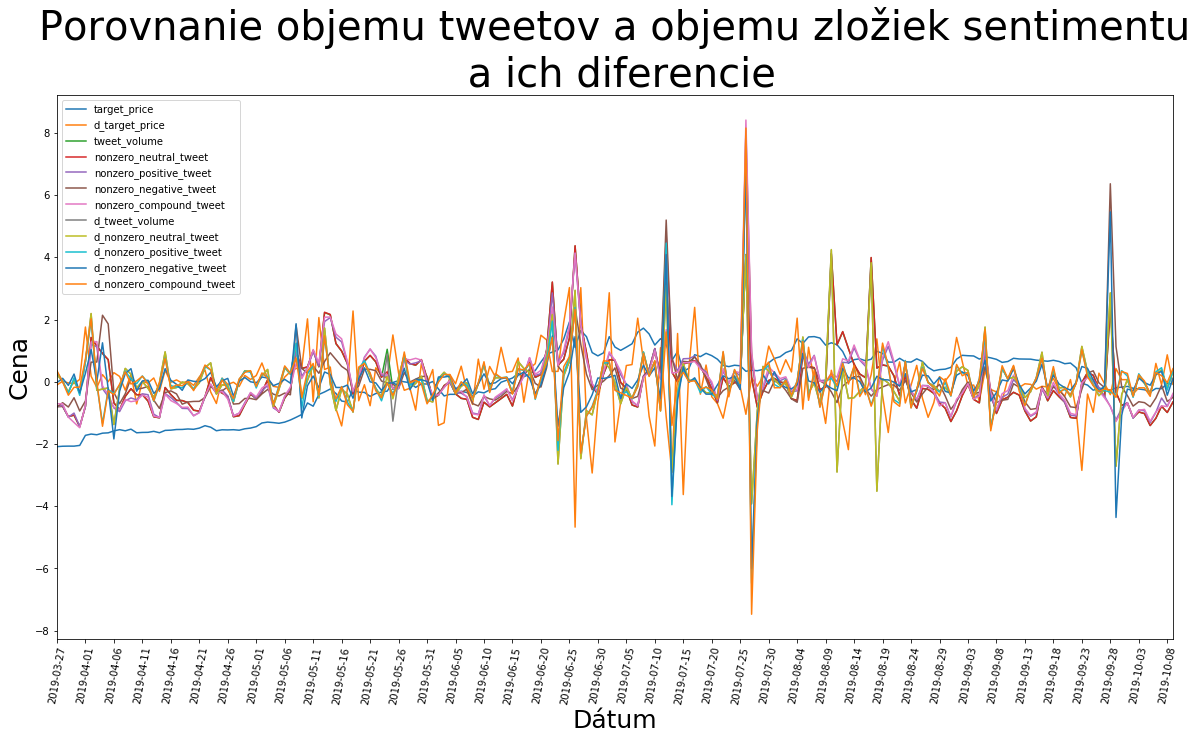

In [270]:
dfc = PlotColumn(dff, ['target_price','d_target_price', 'tweet_volume', 'nonzero_neutral_tweet', 'nonzero_positive_tweet', 'nonzero_negative_tweet', 'nonzero_compound_tweet', 'd_tweet_volume', 'd_nonzero_neutral_tweet', 'd_nonzero_positive_tweet', 'd_nonzero_negative_tweet', 'd_nonzero_compound_tweet'], scaler = StandardScaler(), title ='Porovnanie objemu tweetov a objemu zložiek sentimentu\n a ich diferencie',  ylabel = 'Cena', xlabel = 'Dátum')
PlotCorrelationMatrix(dfc, fontsize = 12)
print("Durbin-Watson test for target_price autocorrelation:  " + str(AutocorrelationTest(dfc.target_price)))
print("Durbin-Watson test for tweet_volume autocorrelation:  " + str(AutocorrelationTest(dfc.tweet_volume)))
print("Durbin-Watson test for nonzero_neutral_tweet autocorrelation:  " + str(AutocorrelationTest(dfc.nonzero_neutral_tweet)))
print("Durbin-Watson test for nonzero_positive_tweet autocorrelation:  " + str(AutocorrelationTest(dfc.nonzero_positive_tweet)))
print("Durbin-Watson test for nonzero_negative_tweet autocorrelation:  " + str(AutocorrelationTest(dfc.nonzero_negative_tweet)))
print("Durbin-Watson test for nonzero_compound_tweet autocorrelation:  " + str(AutocorrelationTest(dfc.nonzero_compound_tweet)))
print("<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation")

# SUMAR TWITTER DATA - úroveň jednotlivých častí sentimentu bez a so zohladnením počtu followerov


In [271]:
df = pd.read_csv("data.csv")
dff = df[['date','open_price', 'close_price','sum_positive_mul_follow', 'sum_neutral_mul_follow', 'sum_negative_mul_follow', 'sum_compound_mul_follow', 'sum_positive', 'sum_neutral', 'sum_negative', 'sum_compound']].copy()
dff['target_price'] = dff['close_price'].shift(-1) 
dff['d_target_price'] = np.append(np.diff(dff['close_price']), 0)
#differences features
dff['d_price_move'] = dff.close_price - dff.open_price
##
dff['d_sum_positive_mul_follow'] = np.insert(np.diff(dff['sum_positive_mul_follow']), 0, 0)
dff['d_sum_neutral_mul_follow'] = np.insert(np.diff(dff['sum_neutral_mul_follow']), 0, 0)
dff['d_sum_negative_mul_follow'] = np.insert(np.diff(dff['sum_negative_mul_follow']), 0, 0)
dff['d_sum_compound_mul_follow'] = np.insert(np.diff(dff['sum_compound_mul_follow']), 0, 0)

dff['d_sum_positive'] = np.insert(np.diff(dff['sum_positive']), 0, 0)
dff['d_sum_neutral'] = np.insert(np.diff(dff['sum_neutral']), 0, 0)
dff['d_sum_negative'] = np.insert(np.diff(dff['sum_negative']), 0, 0)
dff['d_sum_compound'] = np.insert(np.diff(dff['sum_compound']), 0, 0)
dff = dff[:-1]
dff = dff.iloc[1:]
dff.head()

date  open_price  close_price  sum_positive_mul_follow  \
1  2019-03-27     3984.24      4087.07             3.214317e+07   
2  2019-03-28     4087.58      4069.11             3.301160e+07   
3  2019-03-29     4068.30      4098.37             3.450962e+07   
4  2019-03-30     4092.14      4106.66             2.407142e+07   
5  2019-03-31     4105.46      4105.40             2.083678e+07   

   sum_neutral_mul_follow  sum_negative_mul_follow  sum_compound_mul_follow  \
1            3.686044e+08             1.291697e+07             5.812409e+07   
2            3.893312e+08             1.661313e+07             5.451885e+07   
3            3.719599e+08             1.443212e+07             6.272115e+07   
4            3.306417e+08             1.310268e+07             4.038250e+07   
5            2.627016e+08             1.010127e+07             3.536250e+07   

   sum_positive  sum_neutral  sum_negative  ...  d_target_price  d_price_move  \
1      7700.942    68721.946      2158.904  ...          -17.96        102.83   
2      7491.213    68835.597      2429.966  ...           29.26        -18.47   
3      6793.747    61508.605      2186.105  ...            8.29         30.07   
4      6938.961    62041.793      2726.259  ...           -1.26         14.52   
5      6022.011    54494.124      1943.868  ...           52.78         -0.06   

   d_sum_positive_mul_follow  d_sum_neutral_mul_follow  \
1               7.778755e+05              9.745652e+06   
2               8.684311e+05              2.072677e+07   
3               1.498015e+06             -1.737123e+07   
4              -1.043820e+07             -4.131824e+07   
5              -3.234640e+06             -6.794015e+07   

   d_sum_negative_mul_follow  d_sum_compound_mul_follow  d_sum_positive  \
1               -3253408.421               9.164461e+06         911.465   
2                3696159.166              -3.605239e+06        -209.729   
3               -2181003.731               8.202297e+06        -697.466   
4               -1329446.623              -2.233865e+07         145.214   
5               -3001402.025              -5.019998e+06        -916.950   

   d_sum_neutral  d_sum_negative  d_sum_compound  
1       5108.385         -56.932       3698.5849  
2        113.651         271.062      -1458.7223  
3      -7326.992        -243.861      -2078.5753  
4        533.188         540.154      -1534.1484  
5      -7547.669        -782.391       -531.4163  

[5 rows x 22 columns]

In [272]:
dfc = PlotColumn(dff, ['target_price','d_target_price', 'sum_positive_mul_follow', 'sum_neutral_mul_follow', 'sum_negative_mul_follow', 'sum_compound_mul_follow', 'sum_positive', 'sum_neutral', 'sum_negative', 'sum_compound', 'd_sum_positive_mul_follow', 'd_sum_neutral_mul_follow', 'd_sum_negative_mul_follow', 'd_sum_compound_mul_follow', 'd_sum_positive', 'd_sum_neutral', 'd_sum_negative', 'd_sum_compound'], scaler = StandardScaler(), title ='Porovnanie objemu jednotlivých zložiek ich sentimentu\n so zohladnením počtu followerov a ich diferencie',  ylabel = 'Cena', xlabel = 'Dátum')
PlotCorrelationMatrix(dfc, fontsize = 9)
print("Durbin-Watson test for target_price autocorrelation:  " + str(AutocorrelationTest(dfc.target_price)))
print("Durbin-Watson test for tweet_volume autocorrelation:  " + str(AutocorrelationTest(dfc.d_target_price)))
print("Durbin-Watson test for sum_positive_mul_follow autocorrelation:  " + str(AutocorrelationTest(dfc.sum_positive_mul_follow)))
print("Durbin-Watson test for sum_neutral_mul_follow autocorrelation:  " + str(AutocorrelationTest(dfc.sum_neutral_mul_follow)))
print("Durbin-Watson test for sum_negative_mul_follow autocorrelation:  " + str(AutocorrelationTest(dfc.sum_negative_mul_follow)))
print("Durbin-Watson test for sum_compound_mul_follow autocorrelation:  " + str(AutocorrelationTest(dfc.sum_compound_mul_follow)))

print("Durbin-Watson test for d_sum_positive_mul_follow autocorrelation:  " + str(AutocorrelationTest(dfc.d_sum_positive_mul_follow)))
print("Durbin-Watson test for d_sum_neutral_mul_follow autocorrelation:  " + str(AutocorrelationTest(dfc.d_sum_neutral_mul_follow)))
print("Durbin-Watson test for d_sum_negative_mul_follow autocorrelation:  " + str(AutocorrelationTest(dfc.d_sum_negative_mul_follow)))
print("Durbin-Watson test for d_sum_compound_mul_follow autocorrelation:  " + str(AutocorrelationTest(dfc.d_sum_compound_mul_follow)))

print("Durbin-Watson test for sum_positive autocorrelation:  " + str(AutocorrelationTest(dfc.sum_positive)))
print("Durbin-Watson test for sum_neutral autocorrelation:  " + str(AutocorrelationTest(dfc.sum_neutral)))
print("Durbin-Watson test for sum_negative autocorrelation:  " + str(AutocorrelationTest(dfc.sum_negative)))
print("Durbin-Watson test for sum_compound autocorrelation:  " + str(AutocorrelationTest(dfc.sum_compound)))

print("Durbin-Watson test for d_sum_positive autocorrelation:  " + str(AutocorrelationTest(dfc.d_sum_positive)))
print("Durbin-Watson test for d_sum_neutral autocorrelation:  " + str(AutocorrelationTest(dfc.d_sum_neutral)))
print("Durbin-Watson test for d_sum_negative autocorrelation:  " + str(AutocorrelationTest(dfc.d_sum_negative)))
print("Durbin-Watson test for d_sum_compound autocorrelation:  " + str(AutocorrelationTest(dfc.d_sum_compound)))
print("<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation")

Durbin-Watson test for target_price autocorrelation:  0.03176564675590628
Durbin-Watson test for tweet_volume autocorrelation:  2.205179885558197
Durbin-Watson test for sum_positive_mul_follow autocorrelation:  1.110574215756864
Durbin-Watson test for sum_neutral_mul_follow autocorrelation:  0.9050060646029424
Durbin-Watson test for sum_negative_mul_follow autocorrelation:  1.3037164867910742
Durbin-Watson test for sum_compound_mul_follow autocorrelation:  1.169916144338143
Durbin-Watson test for d_sum_positive_mul_follow autocorrelation:  2.5672589555472247
Durbin-Watson test for d_sum_neutral_mul_follow autocorrelation:  2.3438605650195368
Durbin-Watson test for d_sum_negative_mul_follow autocorrelation:  2.540443601548958
Durbin-Watson test for d_sum_compound_mul_follow autocorrelation:  2.659641248242122
Durbin-Watson test for sum_positive autocorrelation:  0.9793812668968862
Durbin-Watson test for sum_neutral autocorrelation:  1.037545587400136
Durbin-Watson test for sum_negative 

# SUMAR TWITTER DATA - priemerné úrovne jednotlivých zložiek sentimentu bez a so zohladnením počtu followerov

In [273]:
df = pd.read_csv("data.csv")
dff = df[['date','open_price', 'close_price','avg_sum_positive', 'avg_sum_neutral', 'avg_sum_negative', 'avg_sum_compound', 'avg_sum_positive_mul_follow', 'avg_sum_neutral_mul_follow', 'avg_sum_negative_mul_follow', 'avg_sum_compound_mul_follow']].copy()
dff['target_price'] = dff['close_price'].shift(-1) 
dff['d_target_price'] = np.append(np.diff(dff['close_price']), 0)
#differences features
dff['d_price_move'] = dff.close_price - dff.open_price
##
dff['d_avg_sum_positive'] = np.insert(np.diff(dff['avg_sum_positive']), 0, 0)
dff['d_avg_sum_neutral'] = np.insert(np.diff(dff['avg_sum_neutral']), 0, 0)
dff['d_avg_sum_negative'] = np.insert(np.diff(dff['avg_sum_negative']), 0, 0)
dff['d_avg_sum_compound'] = np.insert(np.diff(dff['avg_sum_compound']), 0, 0)

dff['d_avg_sum_positive_mul_follow'] = np.insert(np.diff(dff['avg_sum_positive_mul_follow']), 0, 0)
dff['d_avg_sum_neutral_mul_follow'] = np.insert(np.diff(dff['avg_sum_neutral_mul_follow']), 0, 0)
dff['d_avg_sum_negative_mul_follow'] = np.insert(np.diff(dff['avg_sum_negative_mul_follow']), 0, 0)
dff['d_avg_sum_compound_mul_follow'] = np.insert(np.diff(dff['avg_sum_compound_mul_follow']), 0, 0)
dff = dff[:-1]
dff = dff.iloc[1:]
dff.head()

date  open_price  close_price  avg_sum_positive  avg_sum_neutral  \
1  2019-03-27     3984.24      4087.07          0.097986         0.874414   
2  2019-03-28     4087.58      4069.11          0.095107         0.873925   
3  2019-03-29     4068.30      4098.37          0.096373         0.872537   
4  2019-03-30     4092.14      4106.66          0.096760         0.865140   
5  2019-03-31     4105.46      4105.40          0.096402         0.872353   

   avg_sum_negative  avg_sum_compound  avg_sum_positive_mul_follow  \
1          0.027470          0.243797                   408.987823   
2          0.030850          0.224739                   419.109795   
3          0.031011          0.221624                   489.539778   
4          0.038016          0.196464                   335.663266   
5          0.031118          0.217033                   333.559257   

   avg_sum_neutral_mul_follow  avg_sum_negative_mul_follow  ...  \
1                 4690.100694                   164.354734  ...   
2                 4942.883584                   210.917482  ...   
3                 5276.476621                   204.728384  ...   
4                 4610.624395                   182.709914  ...   
5                 4205.378076                   161.703177  ...   

   d_target_price  d_price_move  d_avg_sum_positive  d_avg_sum_neutral  \
1          -17.96        102.83            0.004512          -0.001384   
2           29.26        -18.47           -0.002879          -0.000489   
3            8.29         30.07            0.001266          -0.001389   
4           -1.26         14.52            0.000387          -0.007397   
5           52.78         -0.06           -0.000359           0.007213   

   d_avg_sum_negative  d_avg_sum_compound  d_avg_sum_positive_mul_follow  \
1           -0.003037            0.030926                     -22.832862   
2            0.003381           -0.019058                      10.121972   
3            0.000161           -0.003114                      70.429983   
4            0.007005           -0.025160                    -153.876511   
5           -0.006898            0.020569                      -2.104009   

   d_avg_sum_neutral_mul_follow  d_avg_sum_negative_mul_follow  \
1                   -250.475365                     -58.270387   
2                    252.782890                      46.562748   
3                    333.593036                      -6.189099   
4                   -665.852226                     -22.018470   
5                   -405.246319                     -21.006737   

   d_avg_sum_compound_mul_follow  
1                      65.517419  
2                     -47.405267  
3                     197.575159  
4                    -326.624734  
5                       2.977183  

[5 rows x 22 columns]

Durbin-Watson test for target_price autocorrelation:  0.03176564675590628
Durbin-Watson test for tweet_volume autocorrelation:  2.205179885558197
Durbin-Watson test for avg_sum_positive autocorrelation:  1.0250697205745802
Durbin-Watson test for avg_sum_neutral autocorrelation:  1.4783940216433709
Durbin-Watson test for avg_sum_negative autocorrelation:  1.0835998747197035
Durbin-Watson test for avg_sum_compound autocorrelation:  1.1148175712262445
Durbin-Watson test for d_avg_sum_positive autocorrelation:  1.0250697205745802
Durbin-Watson test for d_avg_sum_neutral autocorrelation:  1.4783940216433709
Durbin-Watson test for d_avg_sum_negative autocorrelation:  1.0835998747197035
Durbin-Watson test for d_avg_sum_compound autocorrelation:  1.1148175712262445
Durbin-Watson test for avg_sum_positive_mul_follow autocorrelation:  1.3074727138391355
Durbin-Watson test for avg_sum_neutral_mul_follow autocorrelation:  1.009993505551456
Durbin-Watson test for avg_sum_negative_mul_follow autocor

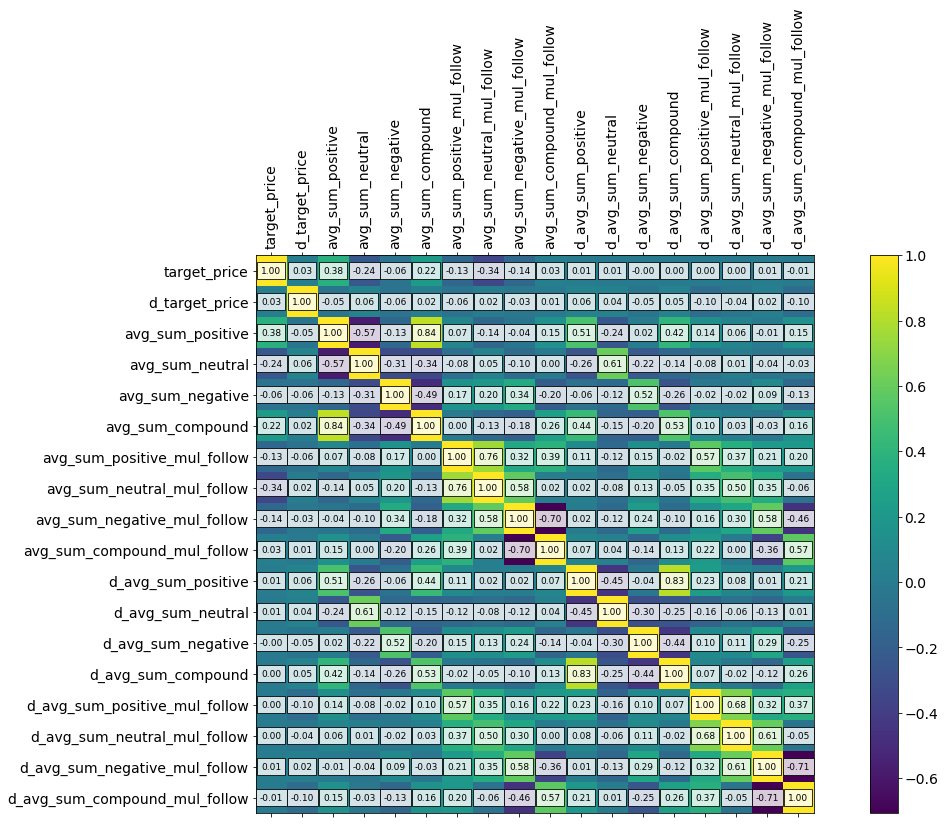

In [274]:
dfc = PlotColumn(dff, ['target_price','d_target_price', 'avg_sum_positive', 'avg_sum_neutral', 'avg_sum_negative', 'avg_sum_compound', 'avg_sum_positive_mul_follow', 'avg_sum_neutral_mul_follow', 'avg_sum_negative_mul_follow', 'avg_sum_compound_mul_follow','d_avg_sum_positive', 'd_avg_sum_neutral', 'd_avg_sum_negative', 'd_avg_sum_compound', 'd_avg_sum_positive_mul_follow', 'd_avg_sum_neutral_mul_follow', 'd_avg_sum_negative_mul_follow', 'd_avg_sum_compound_mul_follow'], scaler = StandardScaler(), title ='Porovnanie objemu jednotlivých zložiek ich sentimentu\n so zohladnením počtu followerov a ich diferencie',  ylabel = 'Cena', xlabel = 'Dátum')
PlotCorrelationMatrix(dfc, fontsize = 9)
print("Durbin-Watson test for target_price autocorrelation:  " + str(AutocorrelationTest(dfc.target_price)))
print("Durbin-Watson test for tweet_volume autocorrelation:  " + str(AutocorrelationTest(dfc.d_target_price)))
print("Durbin-Watson test for avg_sum_positive autocorrelation:  " + str(AutocorrelationTest(dfc.avg_sum_positive)))
print("Durbin-Watson test for avg_sum_neutral autocorrelation:  " + str(AutocorrelationTest(dfc.avg_sum_neutral)))
print("Durbin-Watson test for avg_sum_negative autocorrelation:  " + str(AutocorrelationTest(dfc.avg_sum_negative)))
print("Durbin-Watson test for avg_sum_compound autocorrelation:  " + str(AutocorrelationTest(dfc.avg_sum_compound)))

print("Durbin-Watson test for d_avg_sum_positive autocorrelation:  " + str(AutocorrelationTest(dfc.avg_sum_positive)))
print("Durbin-Watson test for d_avg_sum_neutral autocorrelation:  " + str(AutocorrelationTest(dfc.avg_sum_neutral)))
print("Durbin-Watson test for d_avg_sum_negative autocorrelation:  " + str(AutocorrelationTest(dfc.avg_sum_negative)))
print("Durbin-Watson test for d_avg_sum_compound autocorrelation:  " + str(AutocorrelationTest(dfc.avg_sum_compound)))

print("Durbin-Watson test for avg_sum_positive_mul_follow autocorrelation:  " + str(AutocorrelationTest(dfc.avg_sum_positive_mul_follow)))
print("Durbin-Watson test for avg_sum_neutral_mul_follow autocorrelation:  " + str(AutocorrelationTest(dfc.avg_sum_neutral_mul_follow)))
print("Durbin-Watson test for avg_sum_negative_mul_follow autocorrelation:  " + str(AutocorrelationTest(dfc.avg_sum_negative_mul_follow)))
print("Durbin-Watson test for avg_sum_compound_mul_follow autocorrelation:  " + str(AutocorrelationTest(dfc.avg_sum_compound_mul_follow)))

print("Durbin-Watson test for d_avg_sum_positive_mul_follow autocorrelation:  " + str(AutocorrelationTest(dfc.d_avg_sum_positive_mul_follow)))
print("Durbin-Watson test for d_avg_sum_neutral_mul_follow autocorrelation:  " + str(AutocorrelationTest(dfc.d_avg_sum_neutral_mul_follow)))
print("Durbin-Watson test for d_avg_sum_negative_mul_follow autocorrelation:  " + str(AutocorrelationTest(dfc.d_avg_sum_negative_mul_follow)))
print("Durbin-Watson test for d_avg_sum_compound_mul_follow autocorrelation:  " + str(AutocorrelationTest(dfc.d_avg_sum_compound_mul_follow)))
print("<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation")

In [278]:
df = pd.read_csv("data.csv")
dff = df[['date','open_price','avg_sum_compound_mul_follow', 'close_price','tweet_volume','avg_sum_positive', 'avg_sum_compound', 'avg_sum_negative', 'avg_sum_neutral', 'sum_positive', 'sum_compound']].copy()
dff['target_price'] = dff['close_price'].shift(-1) 
dff['d_target_price'] = np.append(np.diff(dff['close_price']), 0)
#differences features
dff['d_price_move'] = dff.close_price - dff.open_price
##
print(dff.tweet_volume.max())
dff['my_feature1'] = (dff.tweet_volume-dff.tweet_volume.min())* (dff.avg_sum_positive-dff.avg_sum_positive.min())
dff['my_feature2'] = dff.tweet_volume * (dff.avg_sum_positive-dff.avg_sum_negative)
dff['my_feature3'] = (dff.tweet_volume-dff.tweet_volume.min())* (1-dff.avg_sum_negative)
dff['my_feature4'] = (dff.tweet_volume-dff.tweet_volume.min())* (dff.avg_sum_positive-dff.avg_sum_negative)
dff['d_my_feature2'] = np.insert(np.diff(dff['my_feature2']), 0, 0)
dff = dff[:-1]
dff = dff.iloc[1:]
dff.head(2)

207522


date  open_price  avg_sum_compound_mul_follow  close_price  \
1  2019-03-27     3984.24                   739.567517      4087.07   
2  2019-03-28     4087.58                   692.162249      4069.11   

   tweet_volume  avg_sum_positive  avg_sum_compound  avg_sum_negative  \
1         78592          0.097986          0.243797           0.02747   
2         78766          0.095107          0.224739           0.03085   

   avg_sum_neutral  sum_positive  sum_compound  target_price  d_target_price  \
1         0.874414      7700.942    19160.4929       4069.11          -17.96   
2         0.873925      7491.213    17701.7706       4098.37           29.26   

   d_price_move  my_feature1  my_feature2   my_feature3  my_feature4  \
1        102.83   721.079787     5542.038  15681.077462  1137.009119   
2        -18.47   681.936941     5061.247  15795.199479  1047.256476   

   d_my_feature2  
1        968.397  
2       -480.791

In [280]:
dfc = PlotColumn(dff, ['target_price','d_target_price', 'my_feature1', 'my_feature2', 'my_feature3', 'my_feature4'], scaler = MinMaxScaler(), title ='Porovnanie objemu jednotlivých zložiek ich sentimentu\n so zohladnením počtu followerov a ich diferencie',  ylabel = 'Cena', xlabel = 'Dátum')
PlotCorrelationMatrix(dfc, fontsize = 9)
print("Durbin-Watson test for my_feature1 autocorrelation:  " + str(AutocorrelationTest(dfc.my_feature1)))
print("Durbin-Watson test for my_feature2 autocorrelation:  " + str(AutocorrelationTest(dfc.my_feature2)))
print("Durbin-Watson test for my_feature3 autocorrelation:  " + str(AutocorrelationTest(dfc.my_feature3)))
print("Durbin-Watson test for my_feature4 autocorrelation:  " + str(AutocorrelationTest(dfc.my_feature4)))


Durbin-Watson test for my_feature1 autocorrelation:  0.4502323713718974
Durbin-Watson test for my_feature2 autocorrelation:  0.06692695180493251
Durbin-Watson test for my_feature3 autocorrelation:  0.3307627095299479
Durbin-Watson test for my_feature4 autocorrelation:  0.2479107257140295


# Classification SECTION

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC  
 - SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto_deprecated’, coef0=0.0, shrinking=True, probability=False, tol=0.001,    cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)  
 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier  
 - RandomForestClassifier(n_estimators=’warn’, criterion=’gini’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None)
 
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB
 - GaussianNB(priors=None, var_smoothing=1e-09)
 
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier  
 - KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, metric=’minkowski’, metric_params=None, n_jobs=None, **kwargs)


In [297]:
def PrepareDataset():
    df = pd.read_csv("data.csv")
    dff = df[['date', 'close_price','tweet_volume', 'nonzero_neutral_tweet', 'nonzero_positive_tweet', 'nonzero_negative_tweet', 'nonzero_compound_tweet','sum_positive_mul_follow', 'sum_neutral_mul_follow', 'sum_negative_mul_follow', 'sum_compound_mul_follow', 'sum_positive', 'sum_neutral', 'sum_negative', 'sum_compound','avg_sum_positive', 'avg_sum_neutral', 'avg_sum_negative', 'avg_sum_compound', 'avg_sum_positive_mul_follow', 'avg_sum_neutral_mul_follow', 'avg_sum_negative_mul_follow', 'avg_sum_compound_mul_follow']].copy()
    dff['target_price'] = dff['close_price'].shift(-1) 
    dff['d_target_price'] = np.append(np.diff(dff['close_price']), 0)
    #dff['d_price_move'] = dff.close_price - dff.open_price
    dff['d_tweet_volume'] = np.insert(np.diff(dff['tweet_volume']), 0, 0)
    dff['d_nonzero_neutral_tweet'] = np.insert(np.diff(dff['nonzero_neutral_tweet']), 0, 0)
    dff['d_nonzero_positive_tweet'] = np.insert(np.diff(dff['nonzero_positive_tweet']), 0, 0)
    dff['d_nonzero_negative_tweet'] = np.insert(np.diff(dff['nonzero_negative_tweet']), 0, 0)
    dff['d_nonzero_compound_tweet'] = np.insert(np.diff(dff['nonzero_compound_tweet']), 0, 0)
    
    dff['d_sum_positive_mul_follow'] = np.insert(np.diff(dff['sum_positive_mul_follow']), 0, 0)
    dff['d_sum_neutral_mul_follow'] = np.insert(np.diff(dff['sum_neutral_mul_follow']), 0, 0)
    dff['d_sum_negative_mul_follow'] = np.insert(np.diff(dff['sum_negative_mul_follow']), 0, 0)
    dff['d_sum_compound_mul_follow'] = np.insert(np.diff(dff['sum_compound_mul_follow']), 0, 0)

    dff['d_sum_positive'] = np.insert(np.diff(dff['sum_positive']), 0, 0)
    dff['d_sum_neutral'] = np.insert(np.diff(dff['sum_neutral']), 0, 0)
    dff['d_sum_negative'] = np.insert(np.diff(dff['sum_negative']), 0, 0)
    dff['d_sum_compound'] = np.insert(np.diff(dff['sum_compound']), 0, 0)
    
    dff['d_avg_sum_positive'] = np.insert(np.diff(dff['avg_sum_positive']), 0, 0)
    dff['d_avg_sum_neutral'] = np.insert(np.diff(dff['avg_sum_neutral']), 0, 0)
    dff['d_avg_sum_negative'] = np.insert(np.diff(dff['avg_sum_negative']), 0, 0)
    dff['d_avg_sum_compound'] = np.insert(np.diff(dff['avg_sum_compound']), 0, 0)

    dff['d_avg_sum_positive_mul_follow'] = np.insert(np.diff(dff['avg_sum_positive_mul_follow']), 0, 0)
    dff['d_avg_sum_neutral_mul_follow'] = np.insert(np.diff(dff['avg_sum_neutral_mul_follow']), 0, 0)
    dff['d_avg_sum_negative_mul_follow'] = np.insert(np.diff(dff['avg_sum_negative_mul_follow']), 0, 0)
    dff['d_avg_sum_compound_mul_follow'] = np.insert(np.diff(dff['avg_sum_compound_mul_follow']), 0, 0)
    
    dff['my_feature1'] = (dff.tweet_volume-dff.tweet_volume.min())* (dff.avg_sum_positive-dff.avg_sum_positive.min())
    dff['my_feature2'] = dff.tweet_volume * (dff.avg_sum_positive-dff.avg_sum_negative)
    dff['my_feature3'] = (dff.tweet_volume-dff.tweet_volume.min())* (1-dff.avg_sum_negative)
    dff['my_feature4'] = (dff.tweet_volume-dff.tweet_volume.min())* (dff.avg_sum_positive-dff.avg_sum_negative)
    
    dff = dff[:-1]
    dff = dff.iloc[1:]
    dff['target_rise_fall'] = (dff.d_target_price>0.0)
    return dff

def GetColumnSet(choice = None):
    if choice == 'compound':
        ret = ['target_rise_fall','tweet_volume','nonzero_compound_tweet','sum_compound_mul_follow','sum_compound','avg_sum_compound_mul_follow', 'd_tweet_volume','d_nonzero_compound_tweet','d_sum_compound_mul_follow','d_sum_compound','d_avg_sum_compound_mul_follow', 'my_feature1', 'my_feature2', 'my_feature3', 'my_feature4']
        msg = ret
    if choice == 'myfeatures':
        ret = ['tweet_volume', 'nonzero_positive_tweet', 'nonzero_compound_tweet', 'sum_positive', 'sum_compound', 'target_rise_fall','my_feature1','my_feature2','my_feature3','my_feature4',]
        msg = ret
    if choice is None:
        ret = None
        msg = 'ALL'
    print("Selected columns>> " + str(msg)+"\n\n")
    return ret

# Random Forrest whole set

In [306]:
###CLASSIFICATION###DONT MOVE PrepareDataset()  TO SEPARATE BLOCK  - DF must be initialized every time

dff = PrepareDataset()
dff = shuffle(dff)
clf, X_train = Predict(dff,scaler = StandardScaler(), classifier = RandomForestClassifier(n_estimators=101), columns = GetColumnSet("myfeatures"))
feature_importances = pd.DataFrame(clf.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(10)

Selected columns>> ['tweet_volume', 'nonzero_positive_tweet', 'nonzero_compound_tweet', 'sum_positive', 'sum_compound', 'target_rise_fall', 'my_feature1', 'my_feature2', 'my_feature3', 'my_feature4']


(197, 51)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.63      0.48      0.55        25
        True       0.55      0.70      0.62        23

    accuracy                           0.58        48
   macro avg       0.59      0.59      0.58        48
weighted avg       0.59      0.58      0.58        48

----------------Confusion_matrix--------------
[[12 13]
 [ 7 16]]
--------------------Accuracy------------------
0.5833333333333334


importance
sum_compound              0.124434
sum_positive              0.123882
my_feature1               0.120867
nonzero_compound_tweet    0.120556
nonzero_positive_tweet    0.113122
my_feature2               0.107738
my_feature4               0.100598
tweet_volume              0.097062
my_feature3               0.091741

In [311]:
###CLASSIFICATION###DONT MOVE PrepareDataset()  TO SEPARATE BLOCK  - DF must be initialized every time

dff = PrepareDataset()
dff = shuffle(dff)
clf, X_train = Predict(dff,scaler = StandardScaler(), classifier = RandomForestClassifier(n_estimators=101), columns = GetColumnSet('compound'))
feature_importances = pd.DataFrame(clf.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(10)

Selected columns>> ['target_rise_fall', 'tweet_volume', 'nonzero_compound_tweet', 'sum_compound_mul_follow', 'sum_compound', 'avg_sum_compound_mul_follow', 'd_tweet_volume', 'd_nonzero_compound_tweet', 'd_sum_compound_mul_follow', 'd_sum_compound', 'd_avg_sum_compound_mul_follow', 'my_feature1', 'my_feature2', 'my_feature3', 'my_feature4']


(197, 51)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.25      0.22      0.24        18
        True       0.56      0.60      0.58        30

    accuracy                           0.46        48
   macro avg       0.41      0.41      0.41        48
weighted avg       0.45      0.46      0.45        48

----------------Confusion_matrix--------------
[[ 4 14]
 [12 18]]
--------------------Accuracy------------------
0.4583333333333333


importance
d_sum_compound               0.086003
my_feature4                  0.082416
d_nonzero_compound_tweet     0.076835
sum_compound_mul_follow      0.076043
d_sum_compound_mul_follow    0.074875
sum_compound                 0.074467
my_feature1                  0.072943
tweet_volume                 0.072719
d_tweet_volume               0.070530
my_feature2                  0.066867

# GaussianNB - whole dataset

In [313]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK 
dff = PrepareDataset()
dff = shuffle(dff)
clf, X_train = Predict(dff,scaler = StandardScaler() , classifier = GaussianNB(), columns = GetColumnSet())

Selected columns>> ALL


(197, 51)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.18      0.12      0.15        16
        True       0.62      0.72      0.67        32

    accuracy                           0.52        48
   macro avg       0.40      0.42      0.41        48
weighted avg       0.48      0.52      0.49        48

----------------Confusion_matrix--------------
[[ 2 14]
 [ 9 23]]
--------------------Accuracy------------------
0.5208333333333334


In [326]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK 
dff = PrepareDataset()
clf, X_train = Predict(dff,scaler = StandardScaler() , classifier = GaussianNB(), columns = GetColumnSet('myfeatures'))

Selected columns>> ['tweet_volume', 'nonzero_positive_tweet', 'nonzero_compound_tweet', 'sum_positive', 'sum_compound', 'target_rise_fall', 'my_feature1', 'my_feature2', 'my_feature3', 'my_feature4']


(197, 51)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.55      0.25      0.34        24
        True       0.51      0.79      0.62        24

    accuracy                           0.52        48
   macro avg       0.53      0.52      0.48        48
weighted avg       0.53      0.52      0.48        48

----------------Confusion_matrix--------------
[[ 6 18]
 [ 5 19]]
--------------------Accuracy------------------
0.5208333333333334


# SVM - whole dataset

Selected columns>> ALL


(197, 51)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.47      0.30      0.37        23
        True       0.52      0.68      0.59        25

    accuracy                           0.50        48
   macro avg       0.49      0.49      0.48        48
weighted avg       0.49      0.50      0.48        48

----------------Confusion_matrix--------------
[[ 7 16]
 [ 8 17]]
--------------------Accuracy------------------
0.5


C:\Users\kriza\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


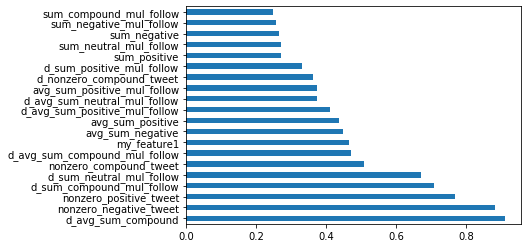

In [323]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK |
dff = PrepareDataset()
dff = shuffle(dff)
clf, X_train = Predict(dff,scaler = StandardScaler(), classifier = svm.LinearSVC(), columns = GetColumnSet())
pd.Series(abs(clf.coef_[0]), index=X_train.columns).nlargest(20).plot(kind='barh')

Selected columns>> ['tweet_volume', 'nonzero_positive_tweet', 'nonzero_compound_tweet', 'sum_positive', 'sum_compound', 'target_rise_fall', 'my_feature1', 'my_feature2', 'my_feature3', 'my_feature4']


(197, 51)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.50      0.47      0.49        19
        True       0.67      0.69      0.68        29

    accuracy                           0.60        48
   macro avg       0.58      0.58      0.58        48
weighted avg       0.60      0.60      0.60        48

----------------Confusion_matrix--------------
[[ 9 10]
 [ 9 20]]
--------------------Accuracy------------------
0.6041666666666666


C:\Users\kriza\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


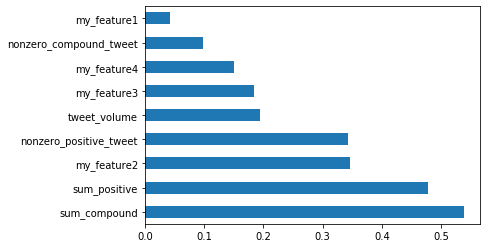

In [334]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK |
dff = PrepareDataset()
dff = shuffle(dff)
clf, X_train = Predict(dff,scaler = StandardScaler(), classifier = svm.LinearSVC(), columns = GetColumnSet('myfeatures'))
pd.Series(abs(clf.coef_[0]), index=X_train.columns).nlargest(20).plot(kind='barh')

In [335]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK |
dff = PrepareDataset()
clf, X_train = Predict(dff,scaler = StandardScaler(), classifier = svm.SVC(gamma='scale'), columns = GetColumnSet())

Selected columns>> ALL


(197, 51)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.50      0.21      0.29        24
        True       0.50      0.79      0.61        24

    accuracy                           0.50        48
   macro avg       0.50      0.50      0.45        48
weighted avg       0.50      0.50      0.45        48

----------------Confusion_matrix--------------
[[ 5 19]
 [ 5 19]]
--------------------Accuracy------------------
0.5


In [340]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK |
dff = PrepareDataset()
dff = shuffle(dff)
clf, X_train = Predict(dff,scaler = StandardScaler(), classifier = svm.SVC(gamma='scale'), columns = GetColumnSet('myfeatures'))

Selected columns>> ['tweet_volume', 'nonzero_positive_tweet', 'nonzero_compound_tweet', 'sum_positive', 'sum_compound', 'target_rise_fall', 'my_feature1', 'my_feature2', 'my_feature3', 'my_feature4']


(197, 51)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.32      0.38      0.34        16
        True       0.66      0.59      0.62        32

    accuracy                           0.52        48
   macro avg       0.49      0.48      0.48        48
weighted avg       0.54      0.52      0.53        48

----------------Confusion_matrix--------------
[[ 6 10]
 [13 19]]
--------------------Accuracy------------------
0.5208333333333334



# KNeighborsClassifier - whole dataset

In [347]:
dff = PrepareDataset()
dff = shuffle(dff)
clf, X_train = Predict(dff,scaler = StandardScaler() , classifier = KNeighborsClassifier(n_neighbors=5), columns = GetColumnSet())

Selected columns>> ALL


(197, 51)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.46      0.58      0.51        19
        True       0.67      0.55      0.60        29

    accuracy                           0.56        48
   macro avg       0.56      0.57      0.56        48
weighted avg       0.58      0.56      0.57        48

----------------Confusion_matrix--------------
[[11  8]
 [13 16]]
--------------------Accuracy------------------
0.5625


In [354]:
dff = PrepareDataset()
dff = shuffle(dff)
clf, X_train = Predict(dff,scaler = StandardScaler() , classifier = KNeighborsClassifier(n_neighbors=5), columns = GetColumnSet('myfeatures'))

Selected columns>> ['tweet_volume', 'nonzero_positive_tweet', 'nonzero_compound_tweet', 'sum_positive', 'sum_compound', 'target_rise_fall', 'my_feature1', 'my_feature2', 'my_feature3', 'my_feature4']


(197, 51)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.50      0.54      0.52        24
        True       0.50      0.46      0.48        24

    accuracy                           0.50        48
   macro avg       0.50      0.50      0.50        48
weighted avg       0.50      0.50      0.50        48

----------------Confusion_matrix--------------
[[13 11]
 [13 11]]
--------------------Accuracy------------------
0.5


# Try for Votting classifiers

In [355]:
def Voting(df, columns = None, scaler = StandardScaler()):
    print(df.shape)
    df.drop(df.tail(7).index,inplace=True) #missing data from news
    
    if columns is None:
        df = df.drop(['date','target_price', 'd_target_price'], axis = 1) # delete non-numeric columns
    else:
        target = df['target_rise_fall']
        df = df[columns].copy()
        df['target_rise_fall'] = target
        
    X = df.loc[:, df.columns != 'target_rise_fall']
    y = df.loc[:, df.columns == 'target_rise_fall']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    X_train_r = X_train.copy()
    if scaler is not None:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    gnb = GaussianNB()
    rf = RandomForestClassifier(n_estimators=101)
    svml = svm.LinearSVC()
    svc = svm.SVC(gamma='scale')
    knb = KNeighborsClassifier(n_neighbors=5)
    
    gnb.fit(X_train, y_train.values.ravel())
    gnb_predict = gnb.predict(X_test)
    
    rf.fit(X_train, y_train.values.ravel())
    rf_predict = rf.predict(X_test)
    
    svml.fit(X_train, y_train.values.ravel())
    svm_predict = svml.predict(X_test)
    
    svc.fit(X_train, y_train.values.ravel())
    svc_predict = svc.predict(X_test)
    
    knb.fit(X_train, y_train.values.ravel())
    knb_predict = knb.predict(X_test)
    
    res = pd.DataFrame(gnb_predict, columns = ['gnb_predict']) 
    res['rf_predict'] = rf_predict
    res['svm_predict'] = svm_predict
    res['svc_predict'] = svc_predict
    res['knb_predict'] = knb_predict
    
    res['tftarget'] = np.array(y_test)
    return res

In [361]:
dff = PrepareDataset()
res = Voting(dff, columns = GetColumnSet('myfeatures'), scaler = StandardScaler())

Selected columns>> ['tweet_volume', 'nonzero_positive_tweet', 'nonzero_compound_tweet', 'sum_positive', 'sum_compound', 'target_rise_fall', 'my_feature1', 'my_feature2', 'my_feature3', 'my_feature4']


(197, 51)


C:\Users\kriza\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [362]:
res.head(5)

gnb_predict  rf_predict  svm_predict  svc_predict  knb_predict  tftarget
0         True       False         True         True        False     False
1         True       False         True         True        False      True
2         True       False         True         True        False     False
3         True       False         True         True         True     False
4         True        True        False         True        False     False

In [363]:
for index, row in res.iterrows():
    count = 0
    if row['gnb_predict'] == True:
        count +=1
    if row['rf_predict'] == True:
        count +=1
    if row['svm_predict'] == True:
        count +=1
    if row['svc_predict'] == True:
        count +=1
    if row['knb_predict'] == True:
        count +=1
    if count >=3:
        res.set_value(index, 'vote_res', True)
        count = 0
        continue
    res.set_value(index, 'vote_res', False)
    count = 0
    

C:\Users\kriza\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\kriza\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [364]:
res.head(50)

gnb_predict  rf_predict  svm_predict  svc_predict  knb_predict  tftarget  \
0          True       False         True         True        False     False   
1          True       False         True         True        False      True   
2          True       False         True         True        False     False   
3          True       False         True         True         True     False   
4          True        True        False         True        False     False   
5          True        True         True         True         True      True   
6          True        True         True         True         True     False   
7          True        True         True         True         True      True   
8         False        True         True         True         True      True   
9         False       False         True         True        False     False   
10         True        True         True         True         True      True   
11         True        True         True         True         True      True   
12         True        True         True         True         True      True   
13         True       False        False         True        False      True   
14        False        True         True         True         True     False   
15         True       False         True         True        False     False   
16         True       False         True         True        False      True   
17         True       False         True         True        False      True   
18        False        True         True         True         True      True   
19        False        True        False         True        False     False   
20         True        True         True         True        False      True   
21         True        True         True         True         True      True   
22         True       False        False         True        False     False   
23         True       False         True         True        False     False   
24         True        True         True         True         True     False   
25         True        True        False         True         True     False   
26         True       False         True         True        False     False   
27         True        True         True         True         True      True   
28         True        True         True         True         True     False   
29         True        True         True         True         True      True   
30        False        True         True         True         True      True   
31        False        True         True         True        False     False   
32         True        True         True         True        False     False   
33         True        True         True         True        False      True   
34        False        True         True         True        False     False   
35         True       False         True         True        False      True   
36         True       False         True         True         True     False   
37        False       False        False        False        False     False   
38         True        True         True         True         True      True   
39        False        True         True         True         True      True   
40         True       False         True         True        False      True   
41         True        True         True         True        False      True   
42        False        True         True         True         True      True   
43         True       False         True         True        False     False   
44         True        True         True         True         True     False   
45         True       False         True         True         True      True   
46         True        True         True         True         True     False   
47         True       False         True         True         True     False   

   vote_res  
0      True  
1      True  
2      True  
3      True  
4      True  

In [365]:

print("---------------------Summary------------------")
print(classification_report(res.tftarget.values.tolist(), res.vote_res.values.tolist()))
print("----------------Confusion_matrix--------------")
print(confusion_matrix(res.tftarget.values.tolist(), res.vote_res.values.tolist()))
print("--------------------Accuracy------------------")
print(accuracy_score(res.tftarget.values.tolist(), res.vote_res.values.tolist()))

---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.80      0.17      0.28        24
        True       0.53      0.96      0.69        24

    accuracy                           0.56        48
   macro avg       0.67      0.56      0.48        48
weighted avg       0.67      0.56      0.48        48

----------------Confusion_matrix--------------
[[ 4 20]
 [ 1 23]]
--------------------Accuracy------------------
0.5625
